In [1]:
import os
os.chdir("../../../")

In [2]:
import scanpy as sc
import surgeon

Using TensorFlow backend.


In [3]:
sc.settings.set_figure_params(dpi=200)

In [102]:
batch_colors = ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059", "#FFDBE5", "#7A4900",]
condition_key = "batch"
cell_type_key = 'celltype'
target_conditions = ['Batch8', 'Batch9']

# Loading four Toy datasets and data preparation

In [5]:
path_to_save = "./results/Figure 1/"
os.makedirs(path_to_save, exist_ok=True)

In [6]:
sc.settings.figdir = path_to_save

In [7]:
adata = sc.read("./data/toy/toy_count.h5ad")
adata

AnnData object with n_obs × n_vars = 36000 × 5000 
    obs: 'batch', 'celltype'

## Number of cells in each batch

In [8]:
adata.obs[condition_key].value_counts()

Batch9    4000
Batch8    4000
Batch7    4000
Batch6    4000
Batch5    4000
Batch4    4000
Batch3    4000
Batch2    4000
Batch1    4000
Name: batch, dtype: int64

## visualization  of the original data

In [9]:
adata = surgeon.tl.normalize(adata,
                             batch_key=condition_key,
                             target_sum=1e4,
                             filter_min_counts=False,
                             logtrans_input=True,
                             size_factors=True, 
                             n_top_genes=2000)
adata

Using 738 HVGs from full intersect set
Using 277 HVGs from n_batch-1 set
Using 246 HVGs from n_batch-2 set
Using 274 HVGs from n_batch-3 set
Using 323 HVGs from n_batch-4 set
Using 142 HVGs from n_batch-5 set
Using 2000 HVGs


AnnData object with n_obs × n_vars = 36000 × 2000 
    obs: 'batch', 'celltype', 'size_factors'

In [103]:
adata.X.min(), adata.X.max()

(0.0, 5.5020804)

In [11]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 45 separate connected components using meta-embedding (experimental)
  n_components


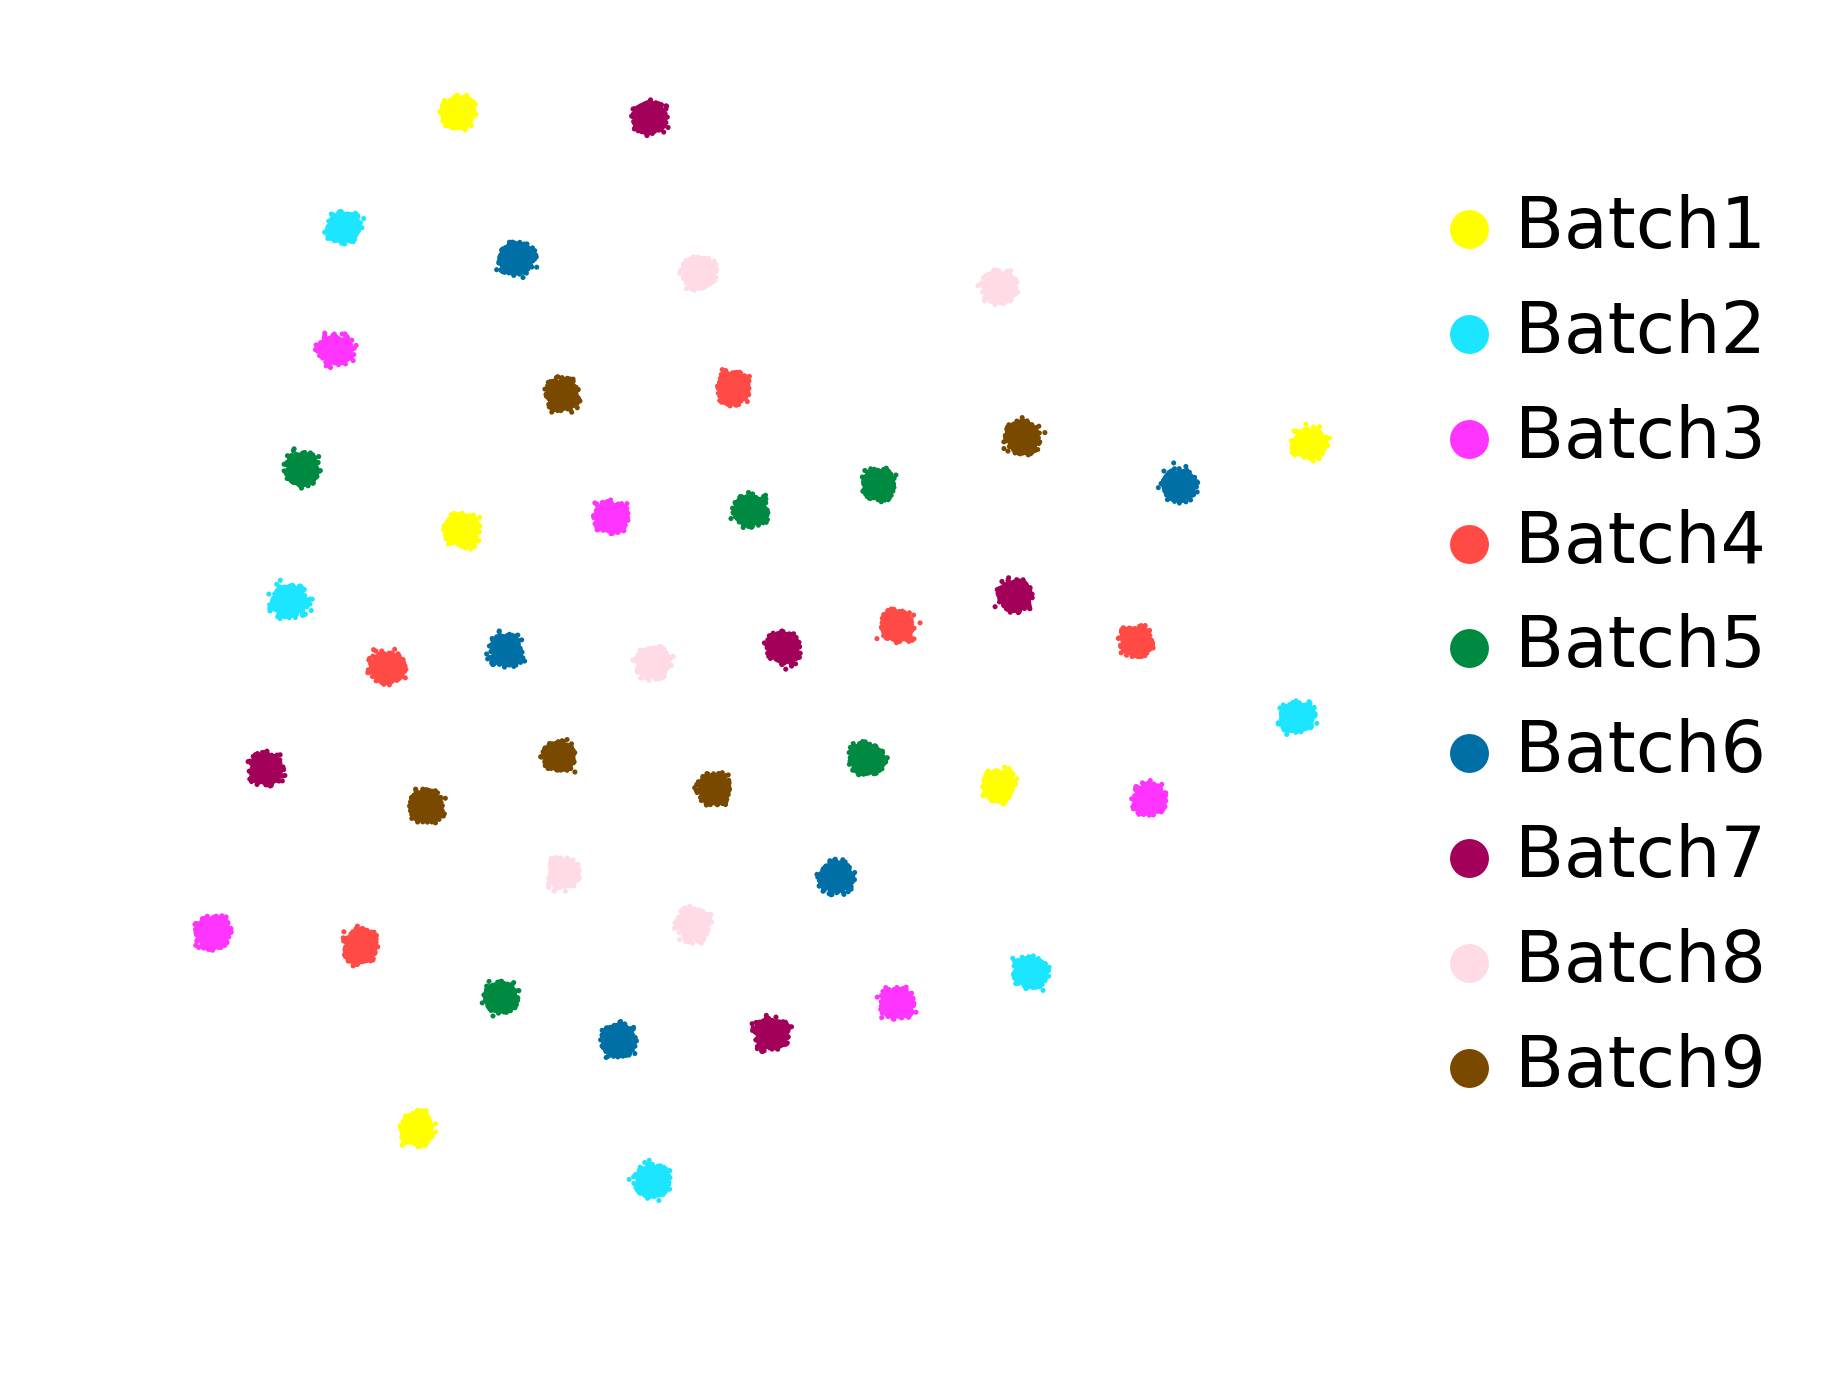

In [104]:
sc.pl.umap(adata, color=condition_key, wspace=0.5, frameon=False, palette=batch_colors,
           save="_original_batch.pdf", title=["", ""],)

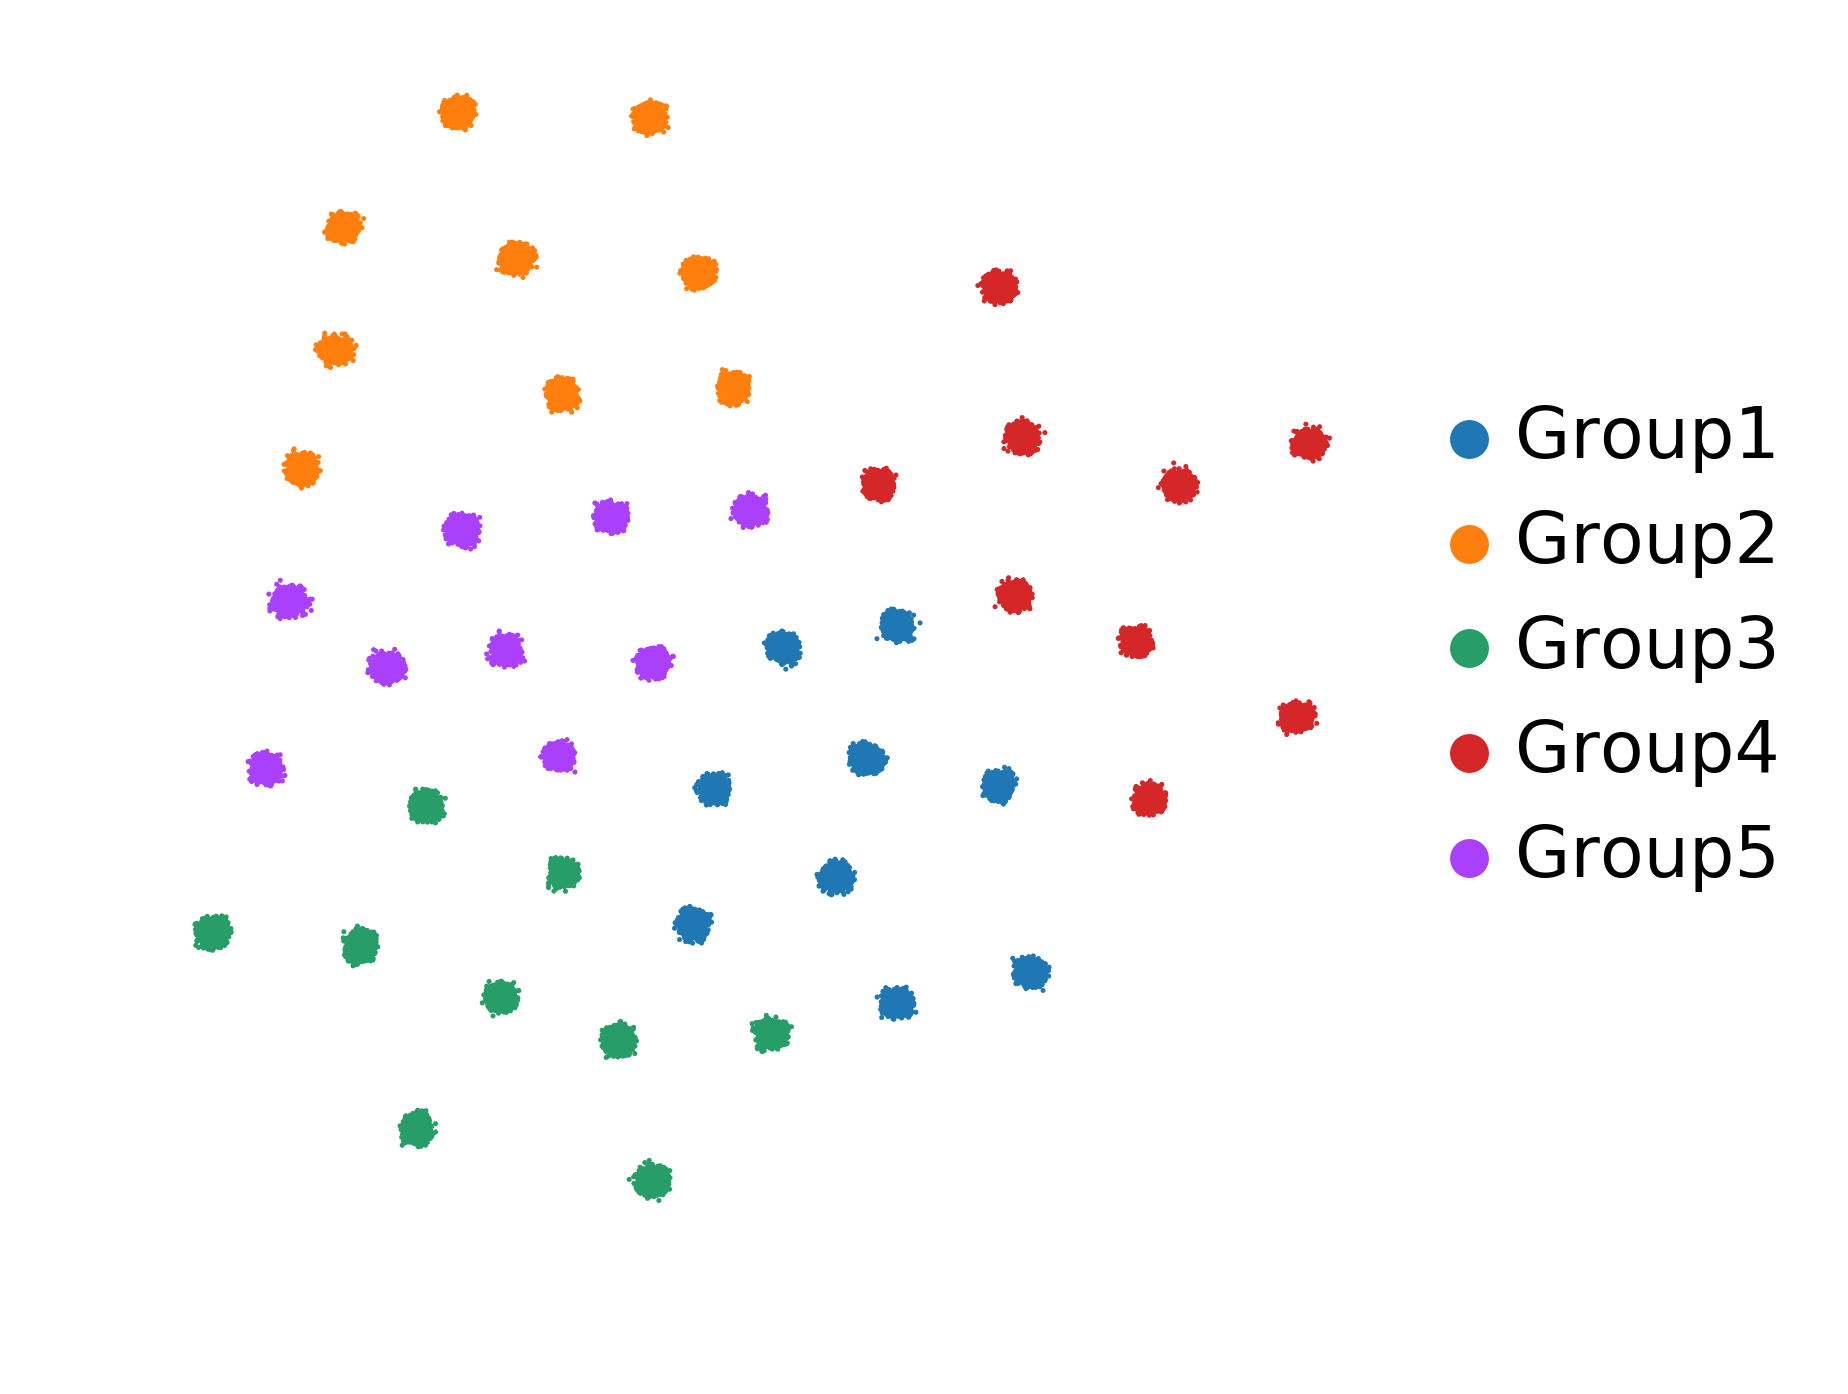

In [105]:
sc.pl.umap(adata, color=cell_type_key, wspace=0.5, frameon=False,
           save="_original_celltype.pdf", title=["", ""],)

## Now we leave out one study (SS2) for training the newtork

In [50]:
adata_for_training = adata[~adata.obs[condition_key].isin(target_conditions)]
adata_for_training

View of AnnData object with n_obs × n_vars = 28000 × 2000 
    obs: 'batch', 'celltype', 'size_factors'
    uns: 'neighbors', 'batch_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'

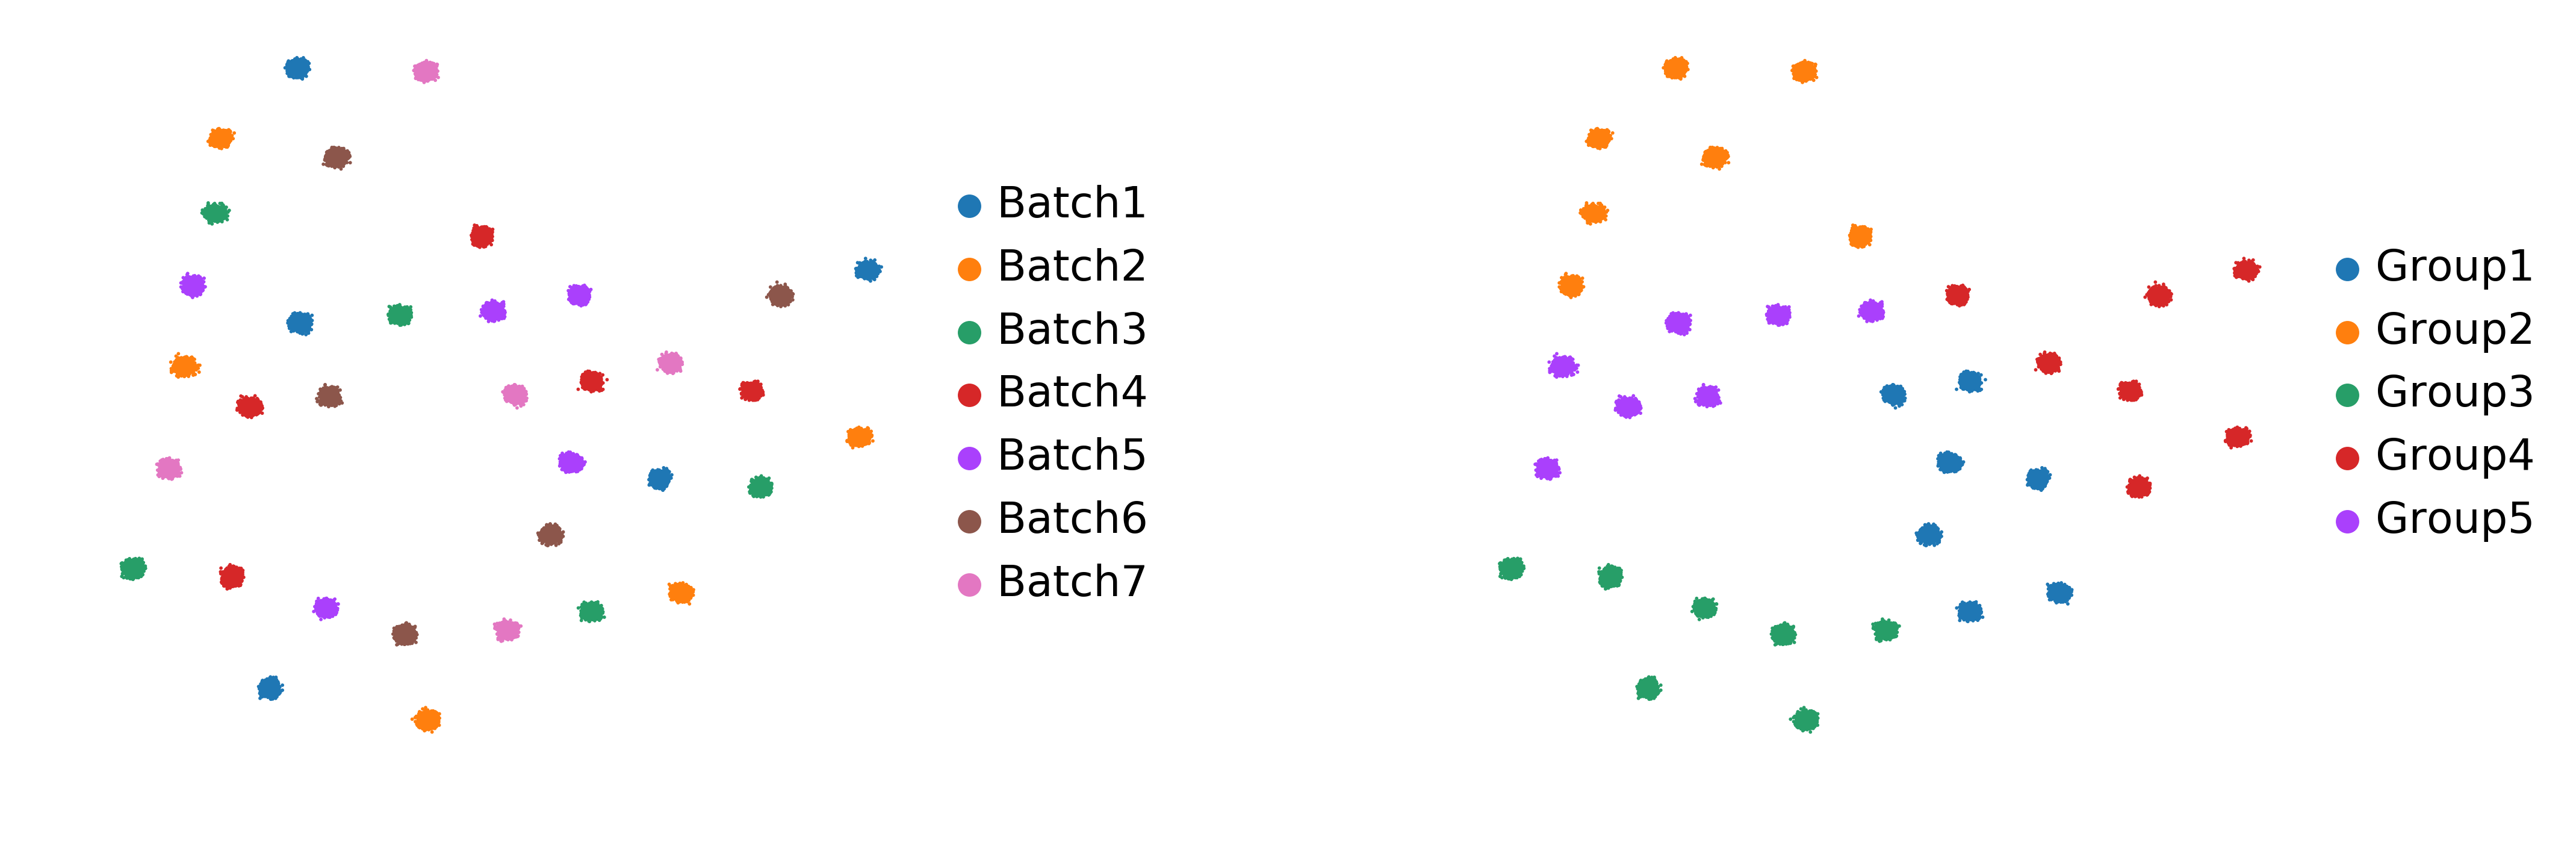

In [52]:
sc.pl.umap(adata_for_training, color=[condition_key, cell_type_key], wspace=0.5, frameon=False,
           save="_toy_before_pretrain.pdf", title=["", ""])

In [53]:
adata_out_of_sample = adata[adata.obs[condition_key].isin(target_conditions)]
adata_out_of_sample

View of AnnData object with n_obs × n_vars = 8000 × 2000 
    obs: 'batch', 'celltype', 'size_factors'
    uns: 'neighbors', 'batch_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'

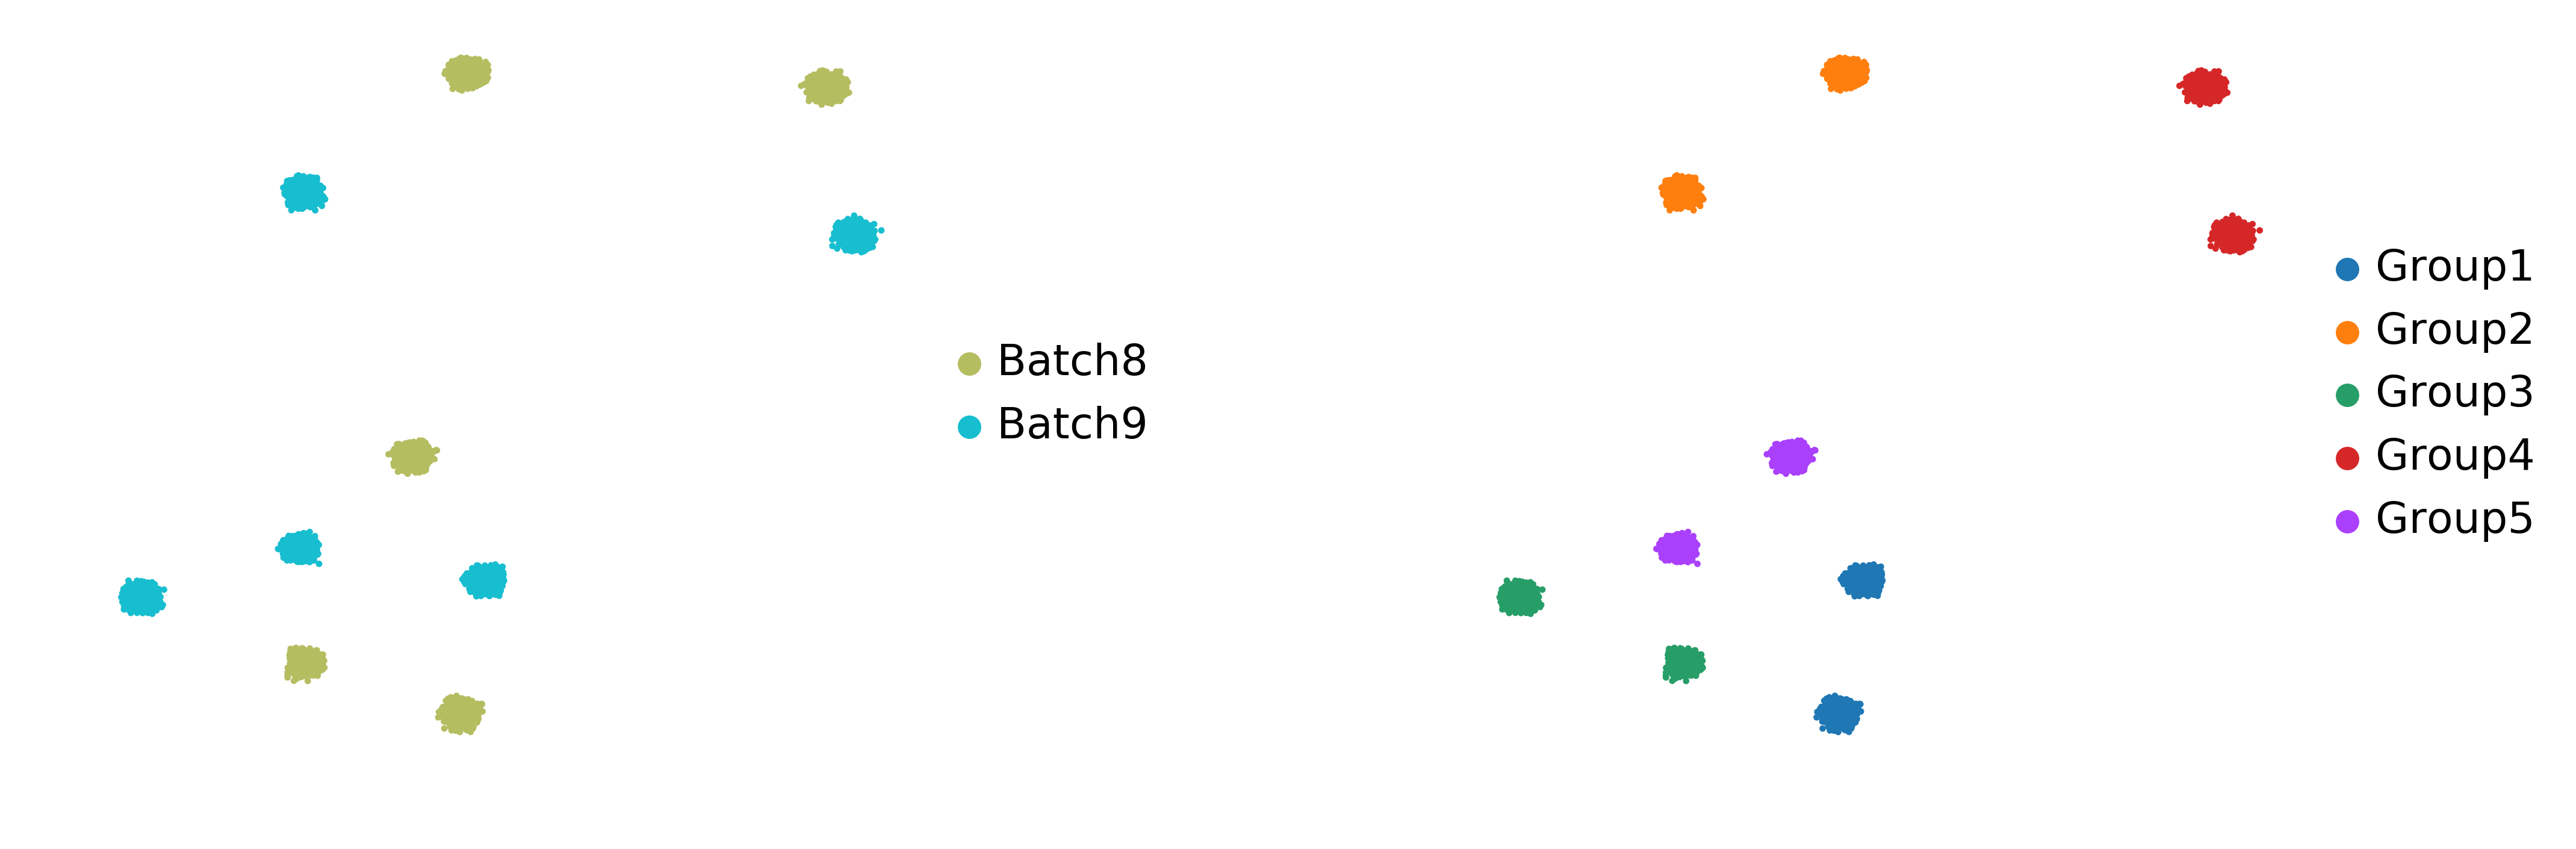

In [54]:
sc.pl.umap(adata_out_of_sample, color=[condition_key, cell_type_key], wspace=0.5, frameon=False,
           save="_toy_before_transfer.pdf", title=["", ""])

## Train/Test Split

In [15]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_for_training, 0.85)

In [16]:
train_adata.shape, valid_adata.shape

((23800, 2000), (4200, 2000))

In [17]:
n_conditions = len(train_adata.obs[condition_key].unique().tolist())

# Create & Train model with training data

In [18]:
network = surgeon.archs.CVAE(x_dimension=train_adata.shape[1], 
                             z_dimension=10,
                             architecture=[128],
                             n_conditions=n_conditions,
                             lr=0.001,
                             alpha=0.00001,
                             eta=1.0,
                             clip_value=3.0,
                             loss_fn='nb',
                             model_path="./models/CVAE/Toy/",
                             dropout_rate=0.2
                            )

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 7)            0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2007)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
_____________________

/home/mohsen/scnet/surgeon/models/_cvae.py:159: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  output=h_disp)


## We assign each study to a numerical label 

In [19]:
conditions = adata.obs[condition_key].unique().tolist()
condition_encoder = surgeon.utils.create_dictionary(conditions, target_conditions)
condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

## Training the network

In [20]:
train_adata.raw.X.min(), train_adata.raw.X.max()

(0.0, 2052.0)

In [21]:
network.train(train_adata,
              valid_adata, 
              condition_key=condition_key,
              le=condition_encoder, 
              n_epochs=10000,
              batch_size=128, 
              early_stop_limit=100,
              lr_reducer=80,
              n_per_epoch=0,
              save=True, 
              retrain=False,
              verbose=2)

Model has been successfully restored!


In [22]:
network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6}

In [70]:
encoder_labels, _ = surgeon.utils.label_encoder(
    adata_for_training, label_encoder=network.condition_encoder, condition_key=condition_key)

In [71]:
latent_adata = network.to_latent(adata_for_training, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 28000 × 10 
    obs: 'batch', 'celltype', 'size_factors'

In [72]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


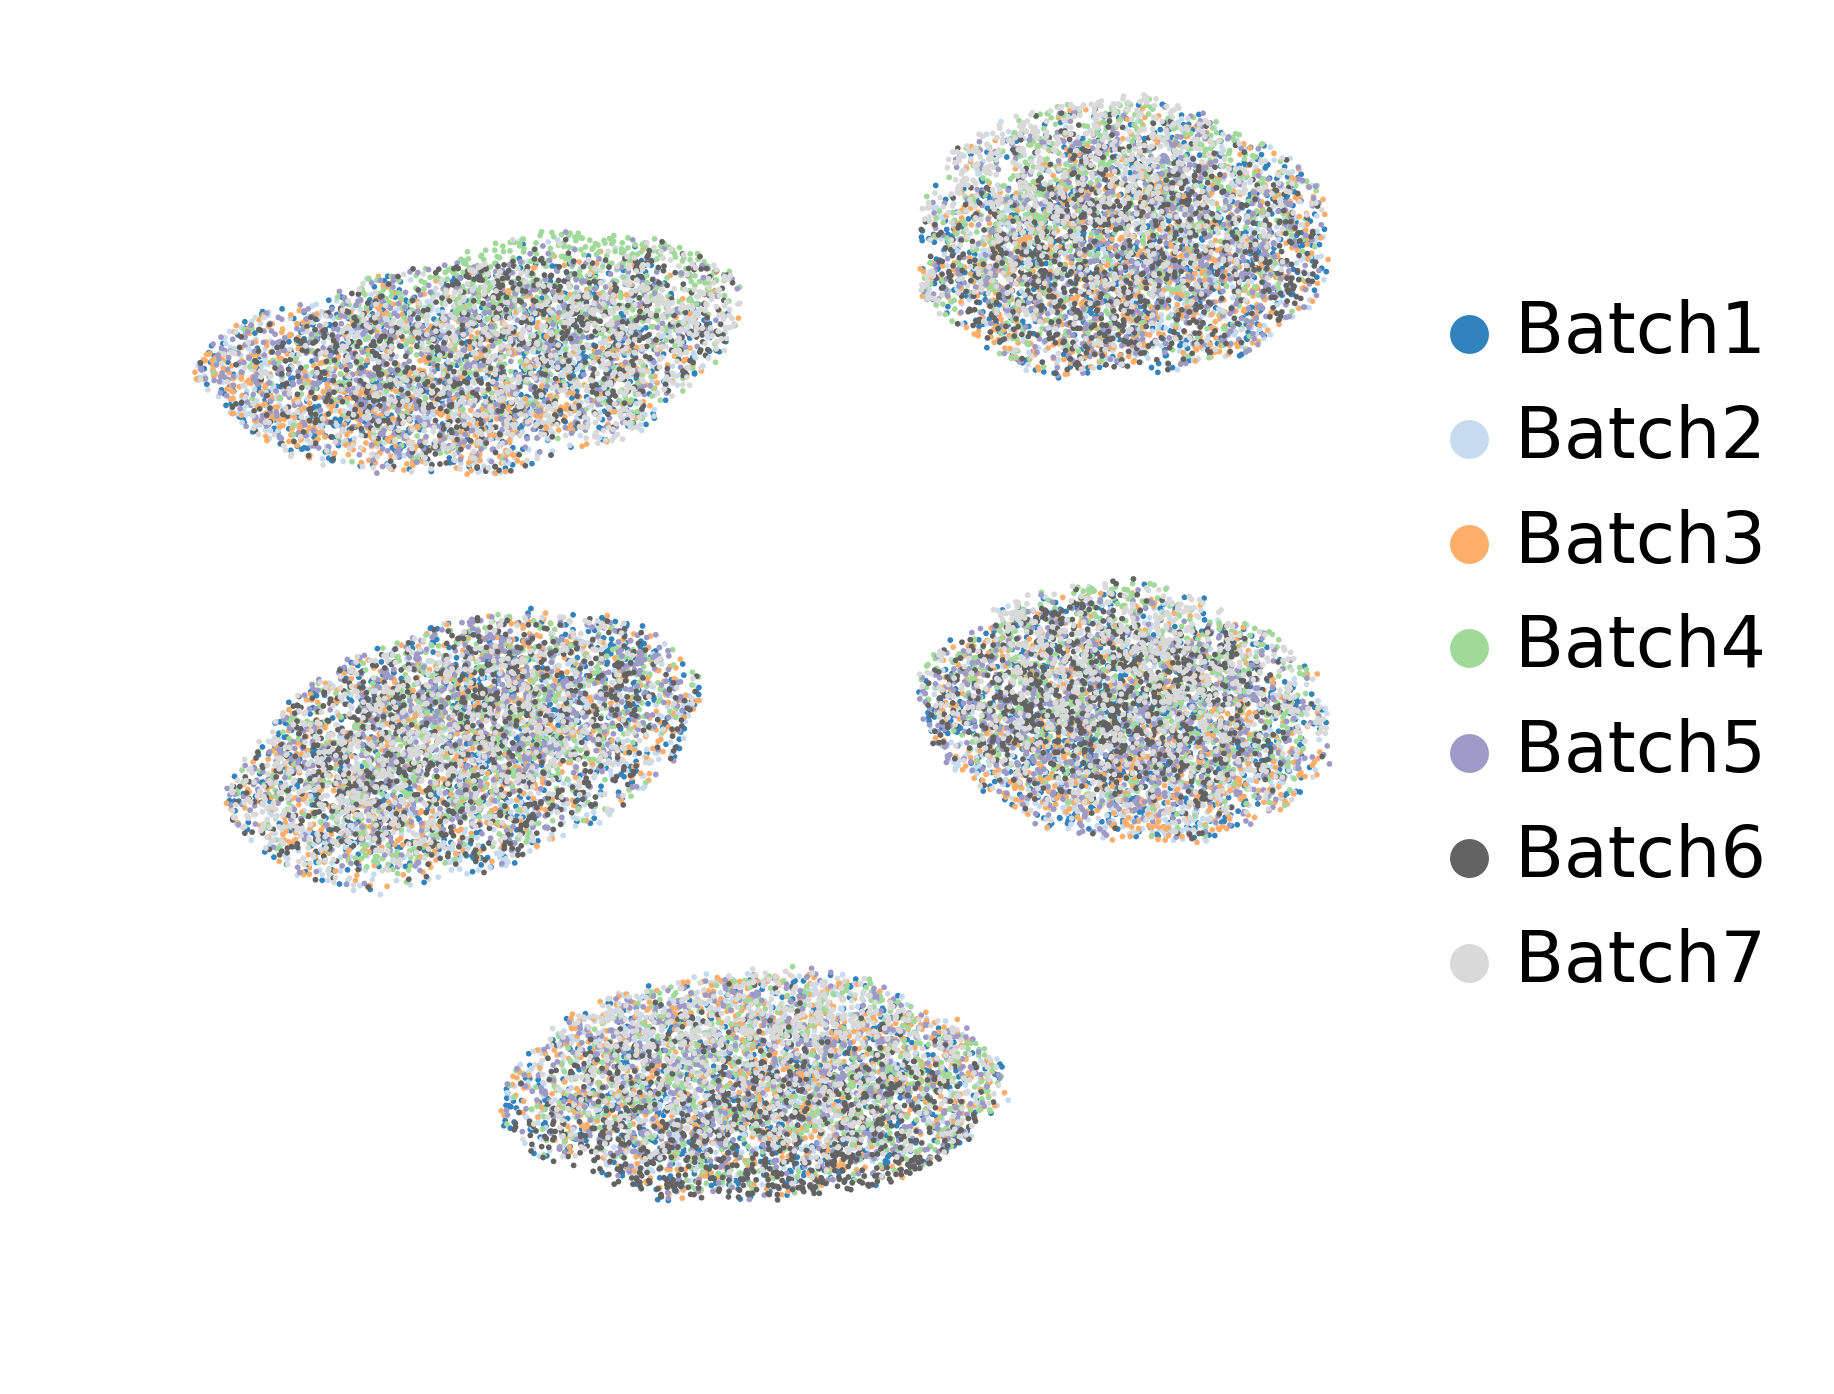

In [74]:
sc.pl.umap(latent_adata, color=condition_key, wspace=0.5, frameon=False, palette='tab20c',
           save="_after_pretrain_batch.pdf", title="")

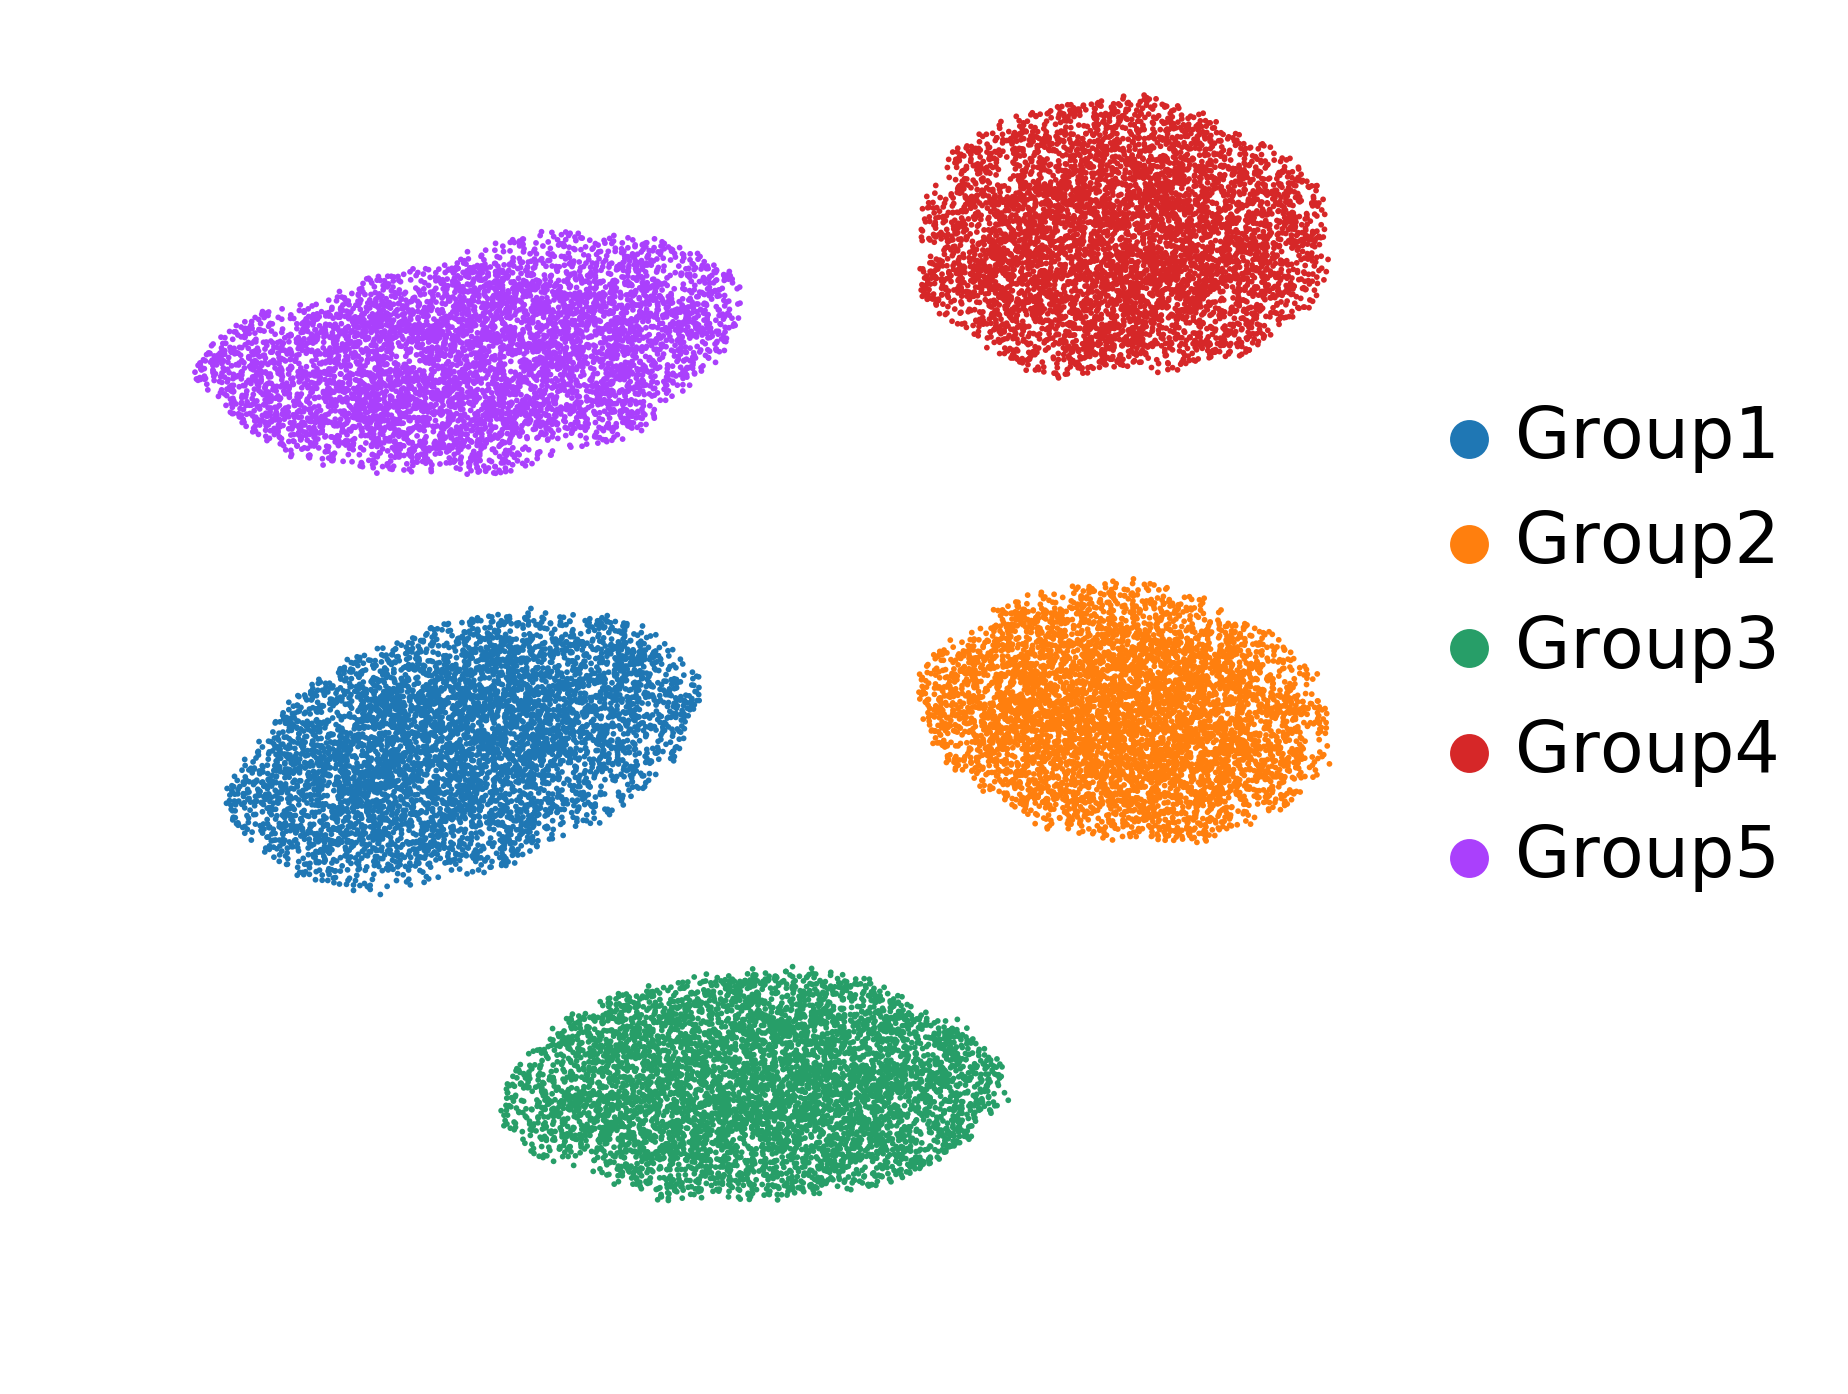

In [75]:
sc.pl.umap(latent_adata, color=cell_type_key, wspace=0.5, frameon=False,
           save="_after_pretrain_celltype.pdf", title=["", ""])

# Perfroming architecture Surgery

In [25]:
new_network = surgeon.operate(network, 
                              new_conditions=target_conditions,
                              remove_dropout=True,
                              init='Xavier', 
                              freeze=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 2000)         0                                            
__________________________________________________________________________________________________
encoder_labels (InputLayer)     (None, 9)            0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2009)         0           data[0][0]                       
                                                                 encoder_labels[0][0]             
__________________________________________________________________________________________________
first_layer (Dense)             (None, 128)          257152      concatenate_3[0][0]              
__________

In [26]:
new_network.condition_encoder

{'Batch1': 0,
 'Batch2': 1,
 'Batch3': 2,
 'Batch4': 3,
 'Batch5': 4,
 'Batch6': 5,
 'Batch7': 6,
 'Batch8': 7,
 'Batch9': 8}

## Train with small new dataset containing out-of-sample condition

In [27]:
train_adata, valid_adata = surgeon.utils.train_test_split(adata_out_of_sample, 0.80)

In [28]:
train_adata.shape, valid_adata.shape

((6400, 2000), (1600, 2000))

In [ ]:
new_network.train(train_adata,
                  valid_adata, 
                  condition_key=condition_key,
                  le=new_network.condition_encoder, 
                  n_epochs=10000,
                  batch_size=128,
                  early_stop_limit=70,
                  lr_reducer=50,
                  n_per_epoch=0,
                  save=True,
                  retrain=True,
                  verbose=2)

In [120]:
encoder_labels, _ = surgeon.utils.label_encoder(adata_out_of_sample, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(8000, 1)

In [121]:
latent_adata = new_network.to_latent(adata_out_of_sample, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 8000 × 10 
    obs: 'batch', 'celltype', 'size_factors'

In [122]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


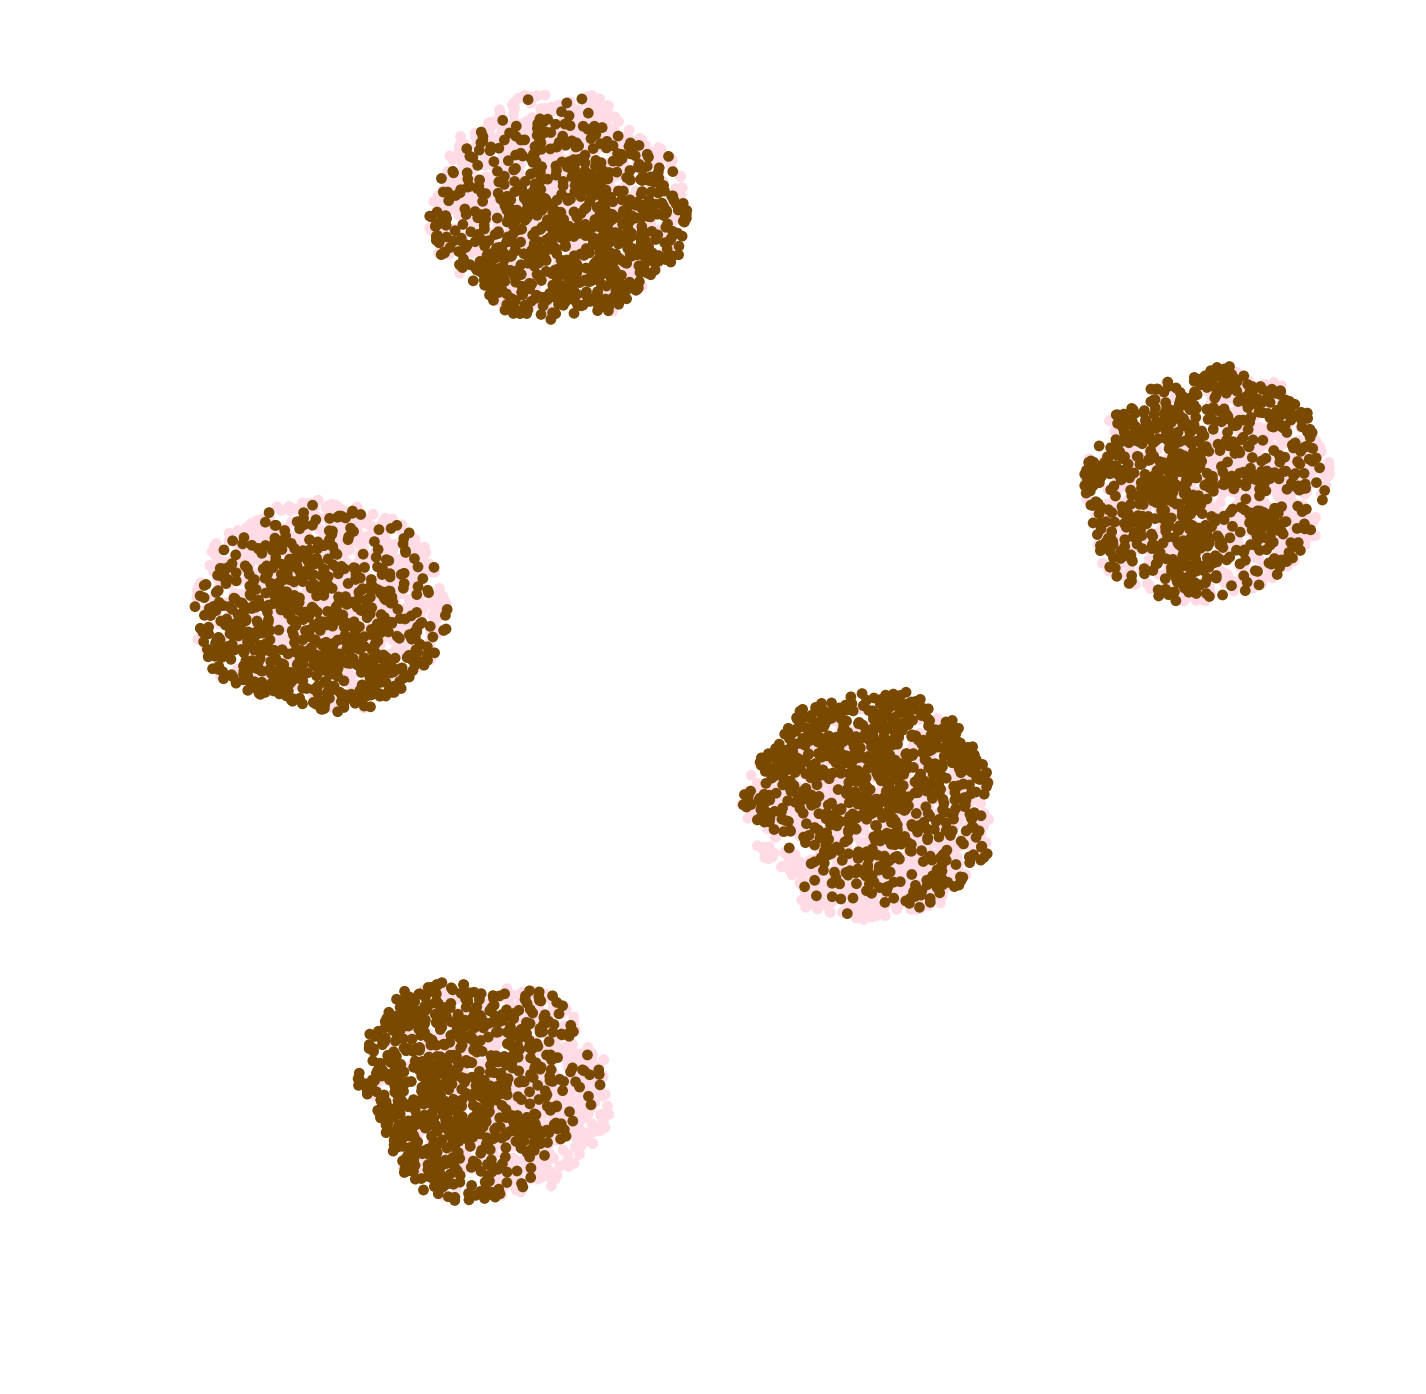

In [123]:
sc.pl.umap(latent_adata, color=condition_key, wspace=0.5, frameon=False, palette=batch_colors[7:],
           save="_after_surgery_batch.pdf", title="", legend_loc=None)

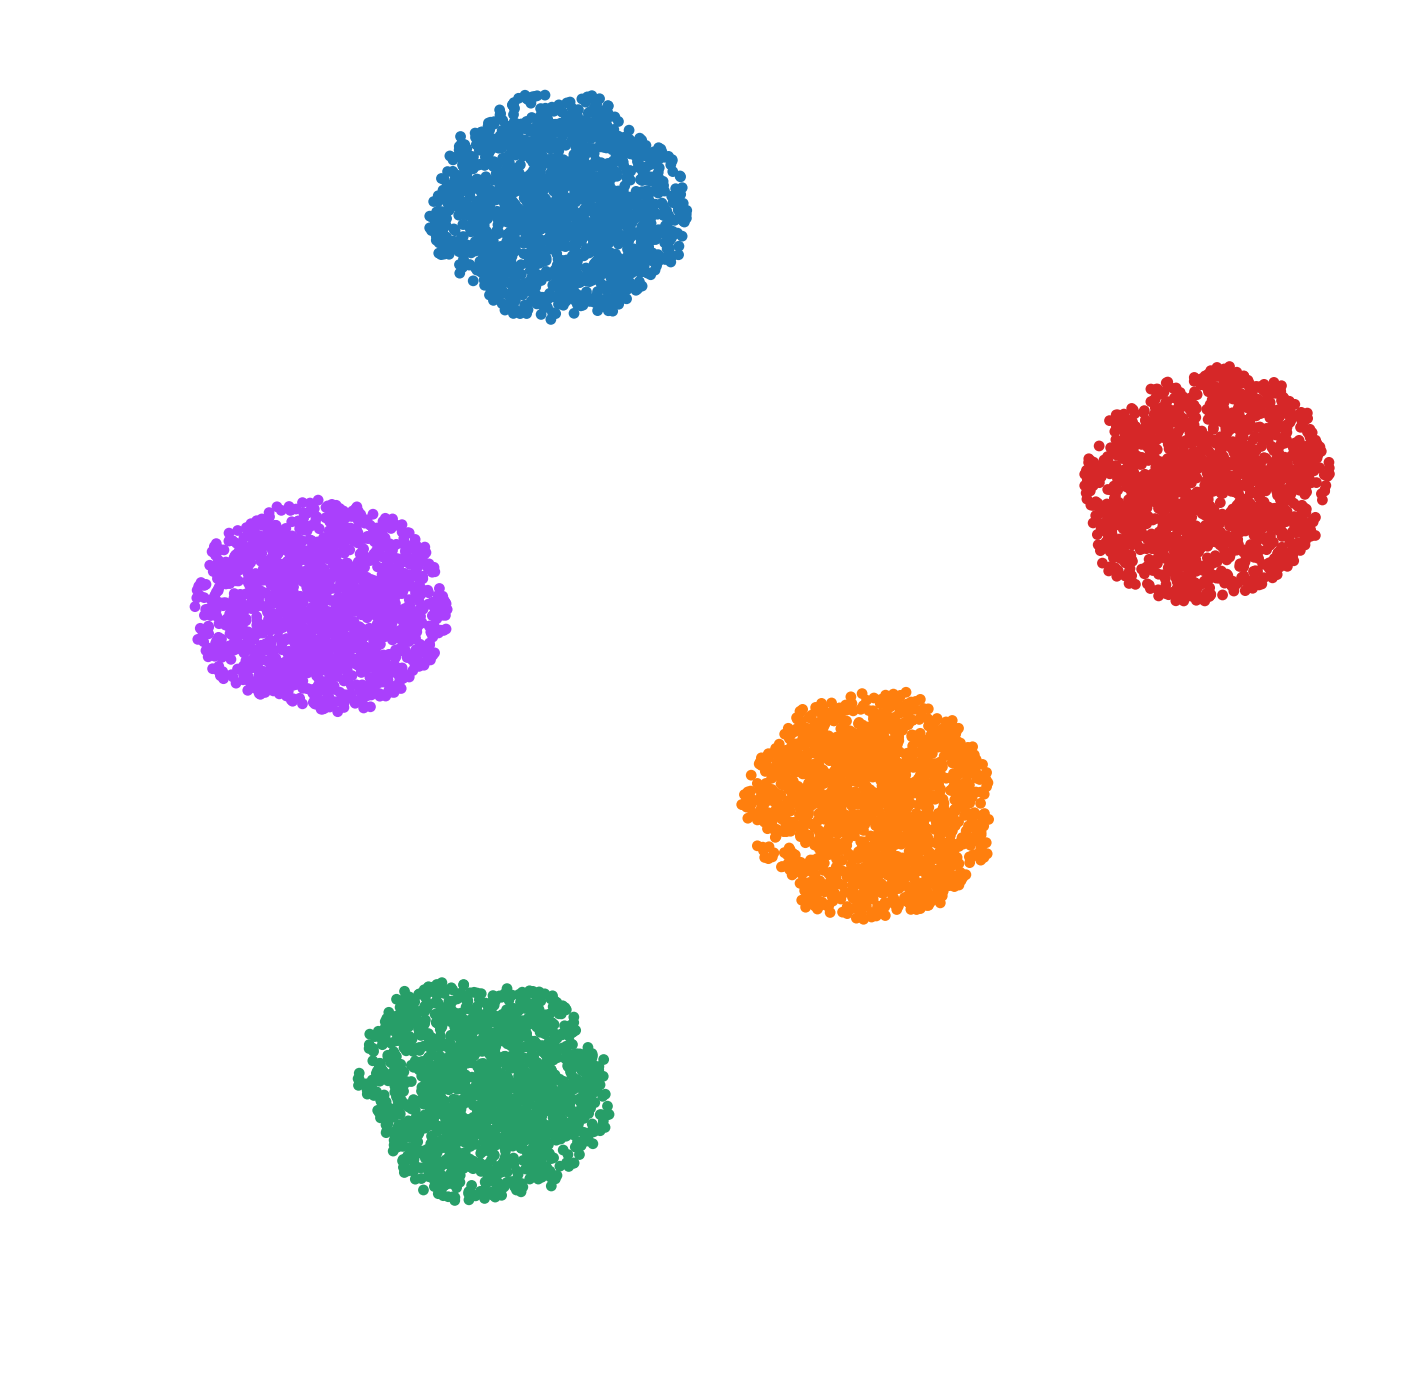

In [124]:
sc.pl.umap(latent_adata, color=cell_type_key, wspace=0.5, frameon=False,
           save="_after_surgery_celltype.pdf", title=["", ""], legend_loc=None)

In [113]:
encoder_labels, _ = surgeon.utils.label_encoder(adata, label_encoder=new_network.condition_encoder, condition_key=condition_key)
encoder_labels.shape

(36000, 1)

In [114]:
latent_adata = new_network.to_latent(adata, encoder_labels)
latent_adata

AnnData object with n_obs × n_vars = 36000 × 10 
    obs: 'batch', 'celltype', 'size_factors'

In [115]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

/home/mohsen/.local/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


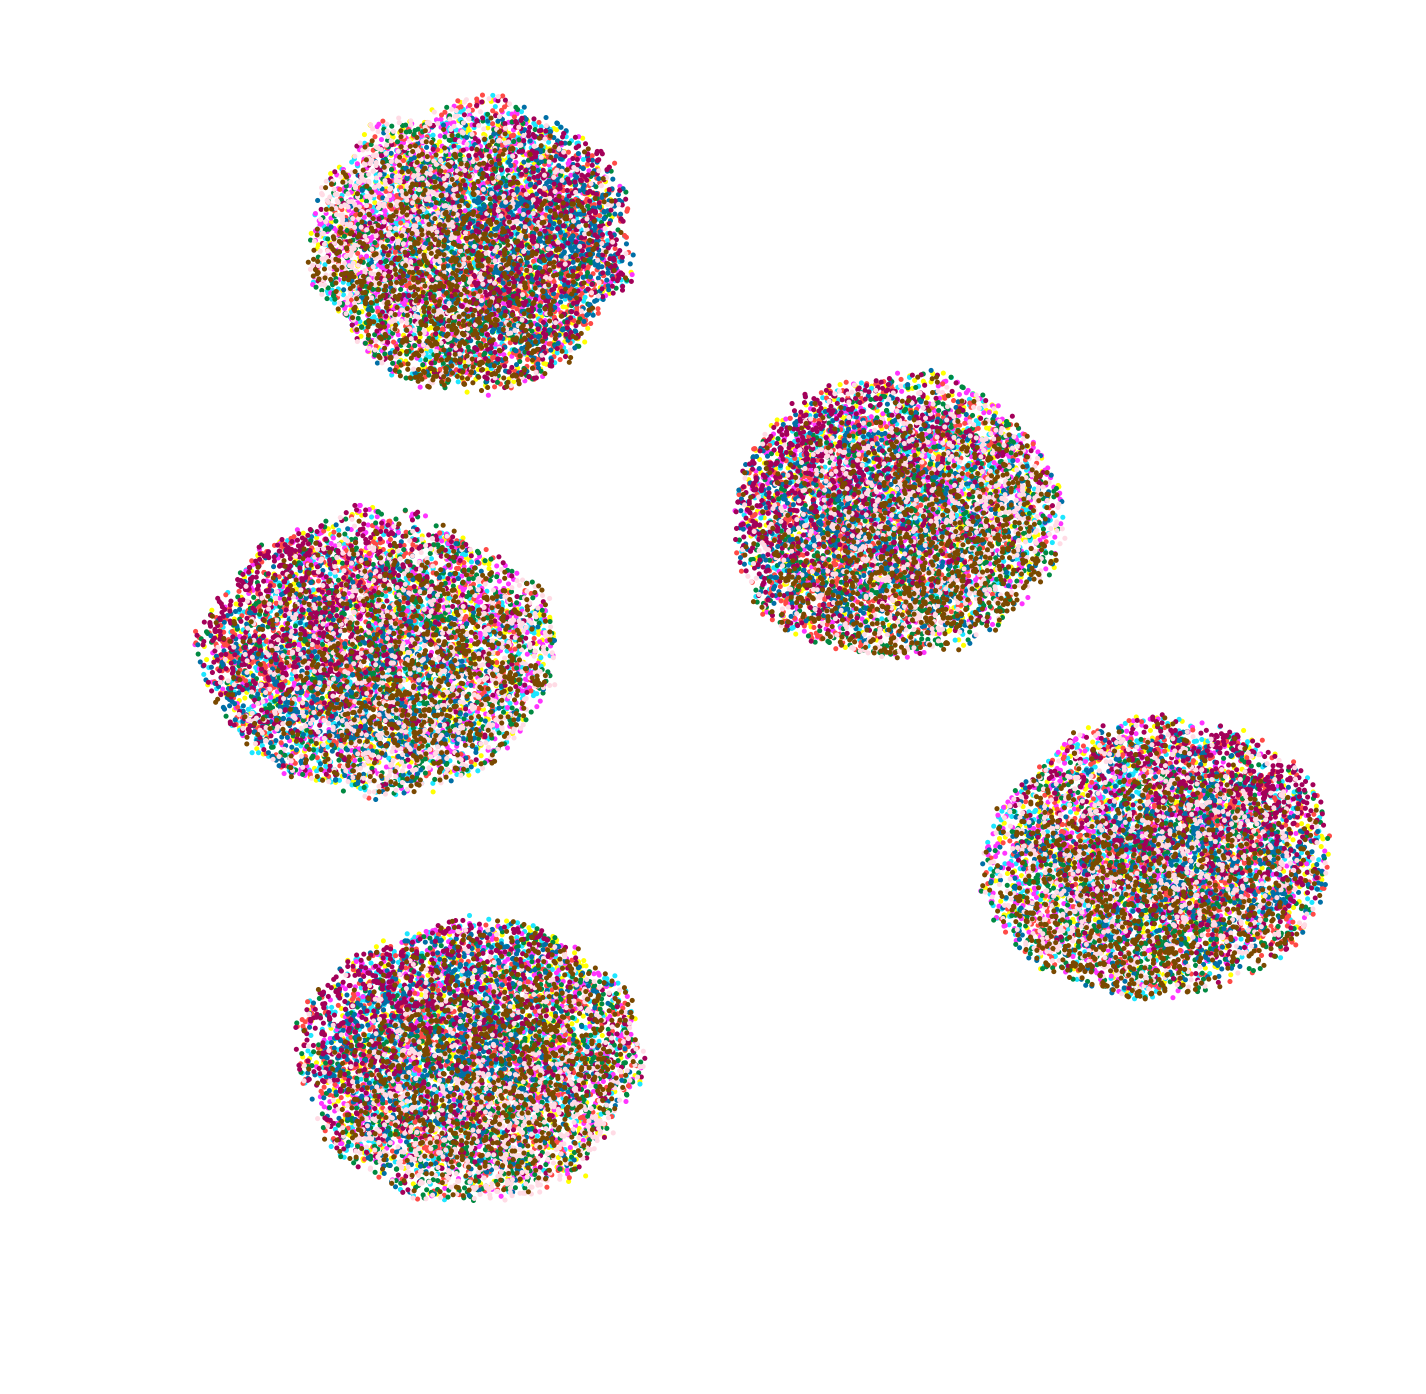

In [119]:
sc.pl.umap(latent_adata, color=condition_key, wspace=0.5, frameon=False, palette=batch_colors,
           save="_after_surgery_all_batch.pdf", title=["", ""], legend_loc=None)

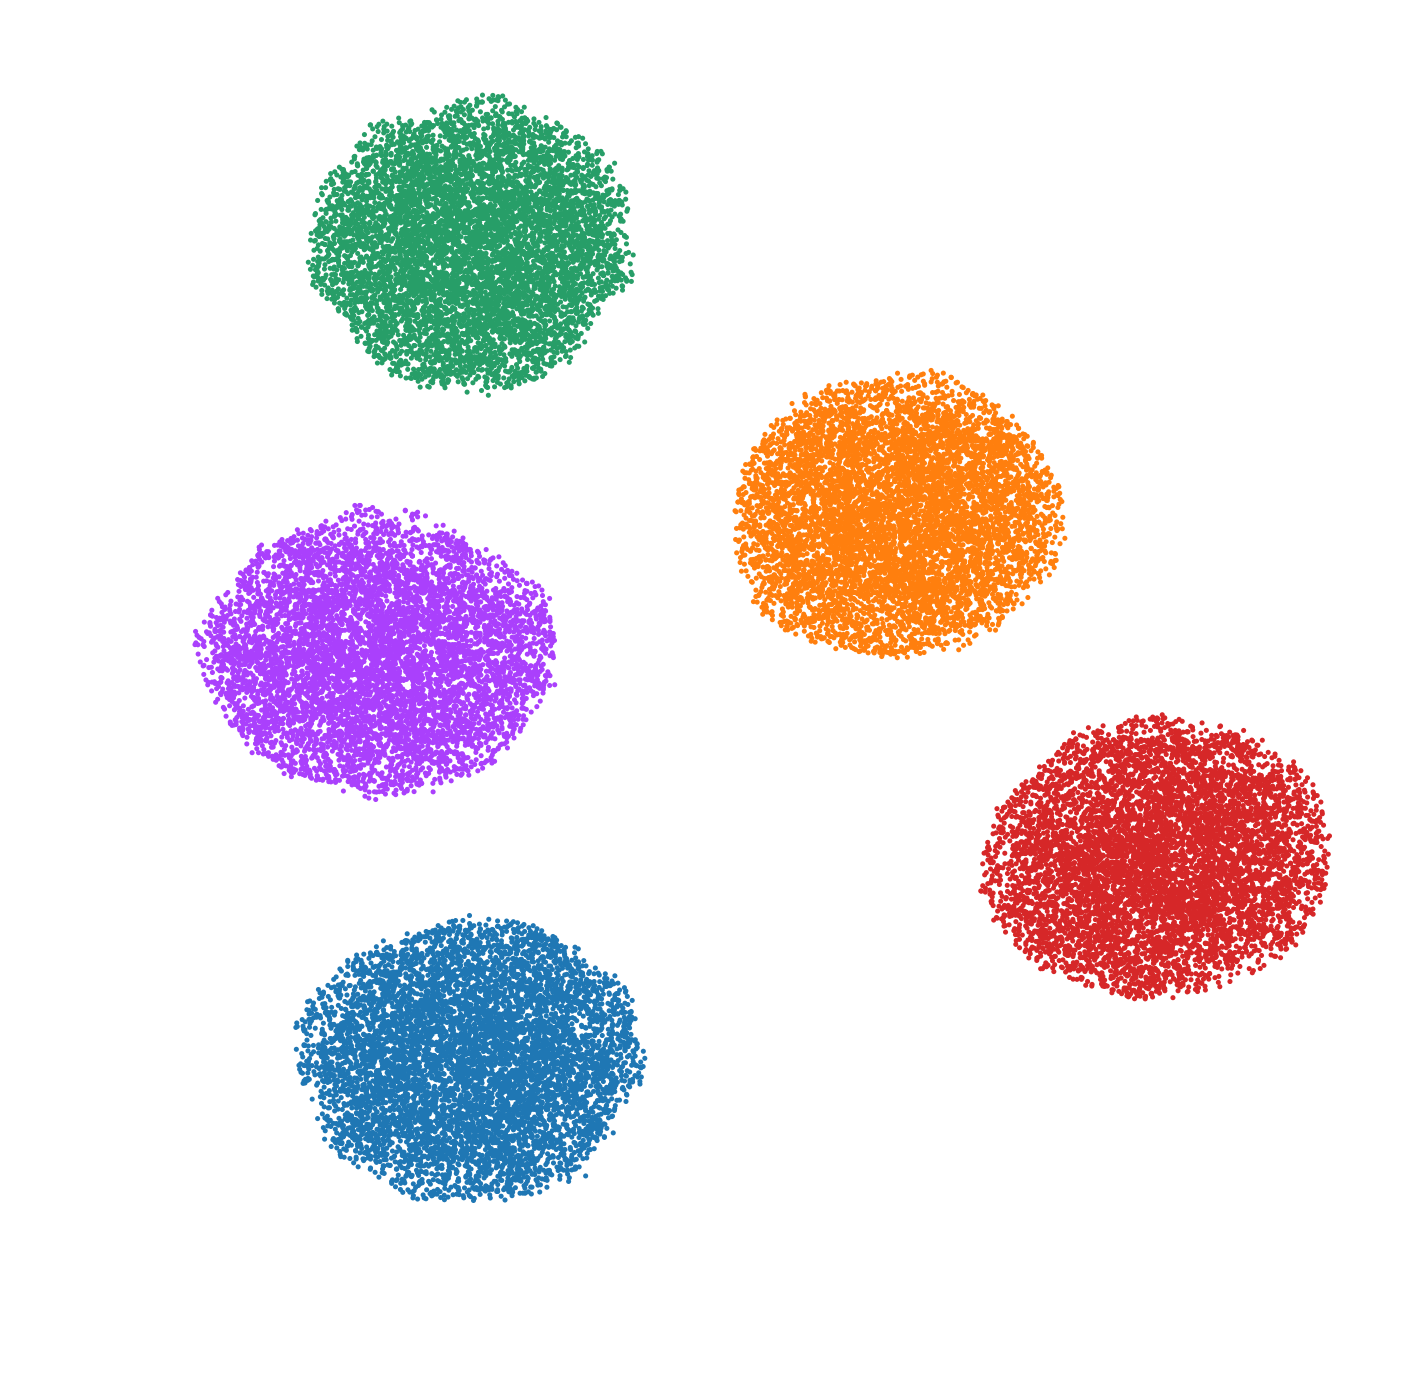

In [118]:
sc.pl.umap(latent_adata, color=cell_type_key, wspace=0.5, frameon=False, 
           save="_after_surgery_all_celltype.pdf", title=["", ""], legend_loc=None)